# Find the GT Board in a Video Image
- Testing on Botez Video

In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
from glob import glob
import sys

sys.path.append("../src/")
from detect_gt import add_edges

In [2]:
%matplotlib inline

In [3]:
%load_ext lab_black
plt.style.use("ggplot")

# Use Video Extractor

In [4]:
from label_extract import VideoBoardExtractor

In [5]:
vbe = VideoBoardExtractor(
    video_fn="../data/Botez/mnxJQaxybWQ.mp4",
    at_first_gt_frame=True,
    predict_fen=True,
    store_gt_boards=True,
    store_irl_boards=True,
    store_irl_video=True,
    save_img_freq=1200,
    gt_board_loc=[5, 290, 5, 290],
    irl_board_loc=[420, 720, 350, 930],
)

	 Loading model '../tensorflow_chessbot/saved_models/frozen_graph.pb'
	 Model restored.


In [6]:
vbe.load_videocap()

In [7]:
vbe.process_video(start_frame=2000, stop_frame=2500)

<VideoCapture 0x7f1f43620b90>


100%|█████████▉| 2499/2500 [00:18<00:00, 136.80it/s]


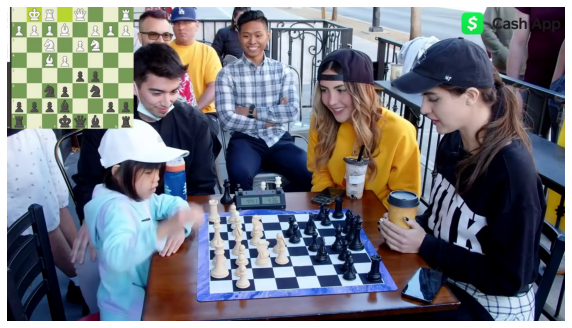

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vbe.this_frame_img, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()

(-0.5, 284.5, 284.5, -0.5)

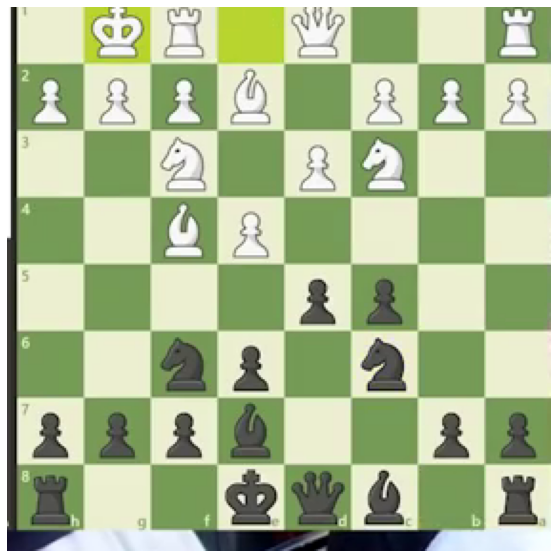

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vbe.gt_board, cv2.COLOR_BGR2RGB))
ax.axis("off")

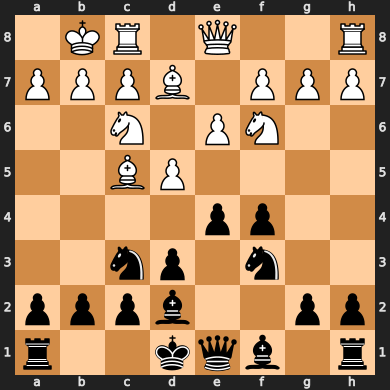

In [10]:
import chess

chess.Board(vbe.fens[2500])

In [11]:
vbe.irl_board.shape

(300, 580, 3)

(-0.5, 579.5, 299.5, -0.5)

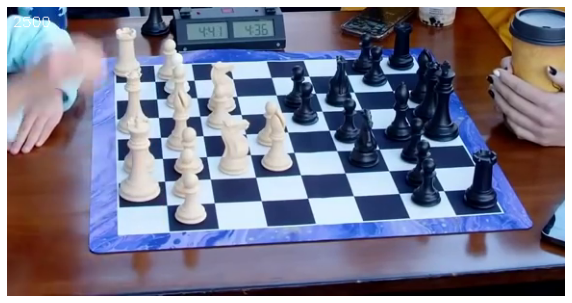

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(vbe.irl_board, cv2.COLOR_BGR2RGB))
ax.axis("off")

# Pull the IRL Board

In [14]:
example_img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")

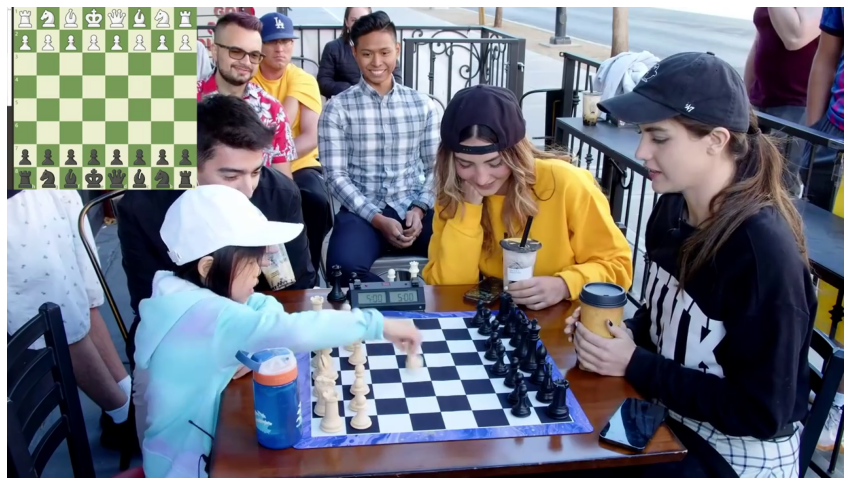

In [15]:
example_img_ = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(example_img_)
ax.axis("off")
plt.show()

# Square Detection with CV2

(-0.5, 1279.5, 719.5, -0.5)

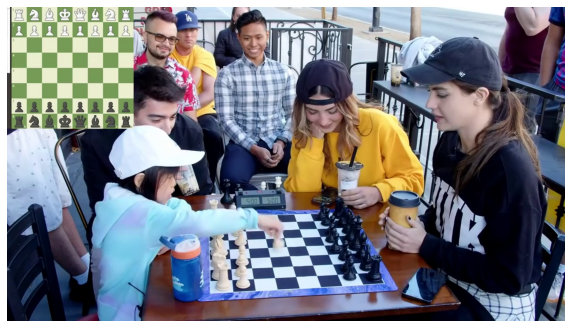

In [12]:
import cv2
import numpy as np

example_img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")

# Load image, grayscale, median blur, sharpen image
image = example_img


def get_squares(
    image, thres_low=160, thres_high=255, min_area=10, max_area=200_000_000
):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, thres_low, thres_high, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours and filter using threshold area
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    image_number = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            x, y, w, h = cv2.boundingRect(c)
            ROI = image[y : y + h, x : x + w]
            # cv2.imwrite("ROI_{}.png".format(image_number), ROI)
            cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)
            image_number += 1
    return image, close, cnts


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.axis("off")

In [13]:
# fig, ax = plt.subplots()
# ax.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
# ax.axis("off")

In [14]:
# for x in range(180, 255, 5):
#     example_img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")
#     print(f"From {x} -> {x+5}")
#     image, close, cnts = get_squares(
#         example_img, thres_low=x, thres_high=x + 5, min_area=100
#     )
#     fig, axs = plt.subplots(2, 1, figsize=(10, 10))
#     axs[0].imshow(cv2.cvtColor(close, cv2.COLOR_BGR2RGB))
#     axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     axs[0].axis("off")
#     axs[1].axis("off")
#     plt.show()

In [15]:
def add_edges(image, area_lim=1000):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    c = 0
    for i in contours:
        area = cv2.contourArea(cv2.UMat(i))
        if area > area_lim:
            if area > max_area:
                max_area = area
                best_cnt = i
                image = cv2.drawContours(image, contours, c, (0, 255, 0), 3)
        c += 1

    mask = np.zeros((gray.shape), np.uint8)
    cv2.drawContours(mask, [best_cnt], 0, 255, -1)
    cv2.drawContours(mask, [best_cnt], 0, 0, 2)

    out = np.zeros_like(gray)
    out[mask == 255] = gray[mask == 255]
    blur = cv2.GaussianBlur(out, (11, 11), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

    c = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000 / 2:
            cv2.drawContours(image, contours, c, (0, 255, 0), 3)
        c += 1
    return image, thresh, contours

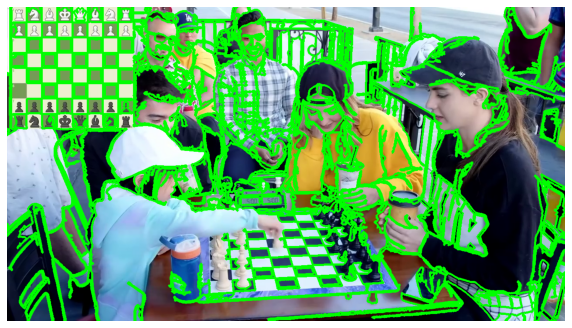

In [16]:
example_img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")
image, thresh, contours = add_edges(example_img)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()

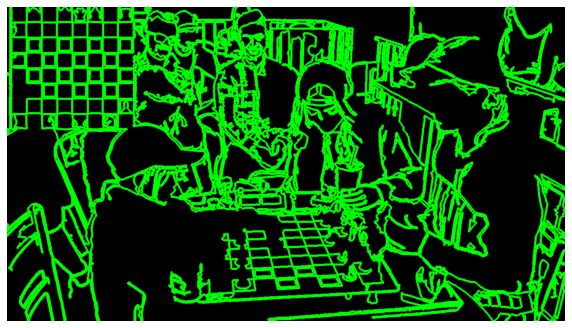

In [17]:
blank = np.zeros_like(image)
c = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > 1000 / 2:
        cv2.drawContours(blank, contours, c, (0, 255, 0), 3)
    c += 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()

# See if we can detect a chess board

## Pick which boxes are for the chess board

In [18]:
import pandas as pd

area_df = pd.DataFrame()
for idx, c in enumerate(contours):
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)
    area_df.loc[idx, "area"] = area
    area_df.loc[idx, "x"] = x
    area_df.loc[idx, "y"] = y
    area_df.loc[idx, "w"] = w
    area_df.loc[idx, "h"] = h

area_df = area_df.astype("int")

In [19]:
idxs

NameError: name 'idxs' is not defined

In [ ]:
area_df["area_round"] = area_df["area"].round(-2)

In [ ]:
area_df["area_round"].value_counts()

In [ ]:
for area in range(100, 1000, 10):
    idxs = area_df.query("area_round == @area").index
    if len(idxs) == 0:
        continue
    print(f"Area of {area} {idxs}")
    blank = np.zeros_like(image)
    for i in idxs:
        cv2.drawContours(blank, contours, i, (0, 255, 0), 3)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    plt.show()

# cv2 Find Chess Board

In [ ]:
example_img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")

res, cont = cv2.findChessboardCorners(example_img, (6, 5))

In [ ]:
example_img.shape

In [ ]:
img = cv2.imread("../data/processed/nxJQaxybWQ/imgs/1200.png")
gray_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray_img, 25, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.axis("off")
plt.show()